In [1]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from utils import real_, abs_, norm_row
from dataset import dataset

In [2]:
signal_idx = [10, 11, 12, 16, 17, 18, 34, 35, 36, 40, 41, 42, 58, 59, 60]
n_signal = len(signal_idx)
data_path = 'data/raw data/MATLAB'
n_cls = 11

In [3]:
dic = {}
with h5py.File(os.path.join(data_path, 'DICAM_TOWER_spectra_H.mat'), 'r') as f:
    healthy = abs_(np.array(f['FFT_X2dotfl']))[:, :, signal_idx].transpose(0, 2, 1)
healthy_reduced = []
for i in range(healthy.shape[0]):
    image = healthy[i, :, :]
    healthy_reduced.append(
        np.array(
            tf.image.resize(
                np.expand_dims(image, axis=-1), (image.shape[0], int(image.shape[1] / 15))
            )[:, :, 0]
        )
    )
healthy_reduced = np.array(healthy_reduced)
dic[0] = healthy_reduced

In [4]:
defective_beams = [5, 6, 13, 17, 18, 22, 51, 57, 66, 67]
for c, b in enumerate(defective_beams):
    with h5py.File(os.path.join(data_path, f'DICAM_TOWER_spectra_A{b}_D40.mat'), 'r') as f:
        defective = abs_(np.array(f['FFT_X2dotfl']))[:, :, signal_idx].transpose(0, 2, 1)
    defective_reduced = []
    for i in range(defective.shape[0]):
        image = defective[i, :, :]
        defective_reduced.append(
            np.array(
                tf.image.resize(
                    np.expand_dims(image, axis=-1), (image.shape[0], int(image.shape[1] / 15))
                )[:, :, 0]
            )
        )
    defective_reduced = np.array(defective_reduced)
    dic[b] = defective_reduced
    if c + 2 == n_cls:
        break

In [5]:
dic.keys()

dict_keys([0, 5, 6, 13, 17, 18, 22, 51, 57, 66, 67])

In [6]:
data = dic
healthy = data[0]
for i in range(healthy.shape[0]):
    healthy[i, :, :] = norm_row(healthy[i, :, :])

healthy_small = np.zeros((healthy.shape[0], n_signal, n_signal))
for row in range(n_signal):
    arg = np.argmax(healthy[0, row, :])
    healthy_small[:, row, :] = healthy[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
for i in range(healthy_small.shape[0]):
    healthy_small[i, :, :] = norm_row(healthy_small[i, :, :])

In [7]:
defective = data[51]
for i in range(defective.shape[0]):
    defective[i, :, :] = norm_row(defective[i, :, :])

defective_small = np.zeros((defective.shape[0], n_signal, n_signal))
for row in range(n_signal):
    arg = np.argmax(defective[0, row, :])
    defective_small[:, row, :] = defective[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
for i in range(defective_small.shape[0]):
    defective_small[i, :, :] = norm_row(defective_small[i, :, :])

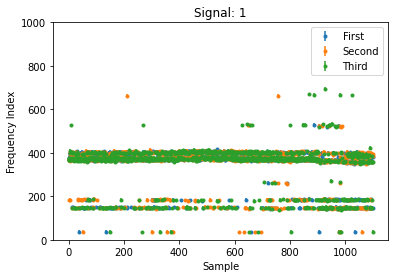

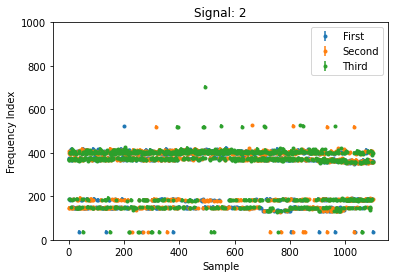

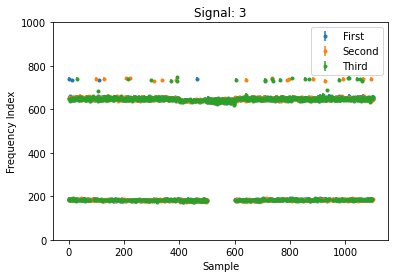

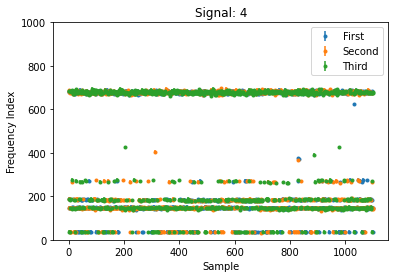

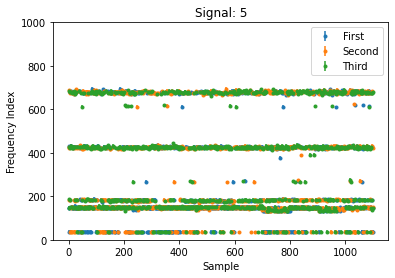

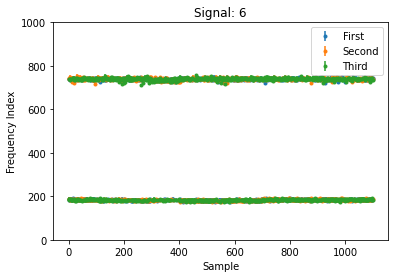

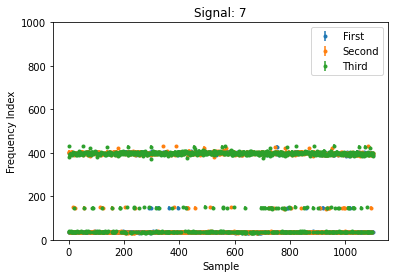

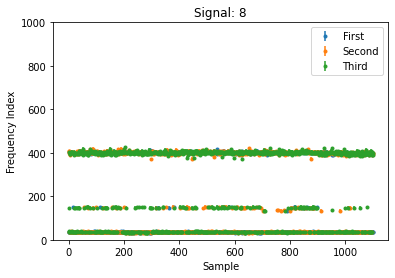

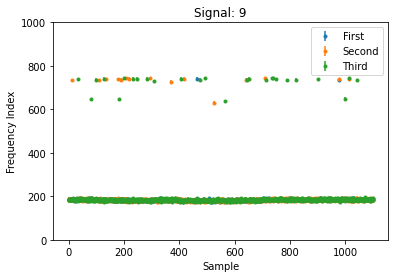

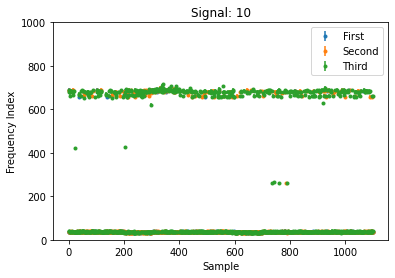

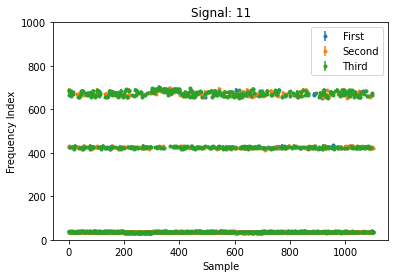

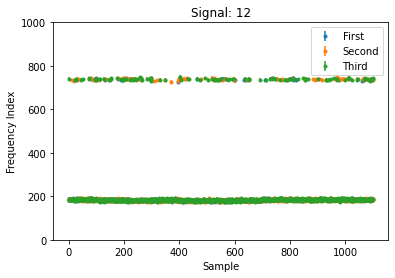

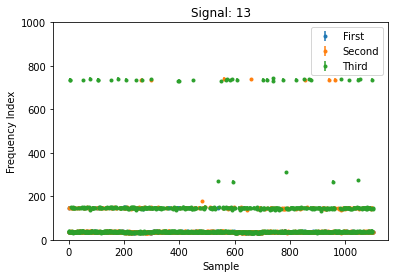

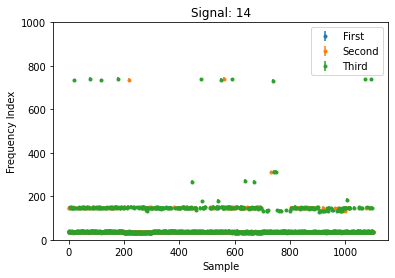

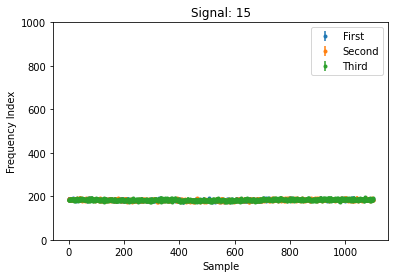

In [8]:
for sig in range(15):
    maxs1, maxs2, maxs3 = [], [], []
    for key in dic.keys():
        data = dic[key]
        idxs = np.argsort(np.abs(data[:, sig, :]), axis=-1)
        maxs1.append(idxs[:, -1])
        maxs2.append(idxs[:, -2])
        maxs3.append(idxs[:, -3])
    maxs1 = np.concatenate(maxs1)
    maxs2 = np.concatenate(maxs2)
    maxs3 = np.concatenate(maxs3)
    plt.figure()
    plt.errorbar(np.arange(len(maxs1)), maxs1, yerr=7*np.ones(len(maxs1)), fmt='.', label='First')
    plt.errorbar(np.arange(len(maxs2)), maxs2, yerr=7*np.ones(len(maxs2)), fmt='.', label='Second')
    plt.errorbar(np.arange(len(maxs3)), maxs3, yerr=7*np.ones(len(maxs3)), fmt='.', label='Third')
    plt.xlabel('Sample')
    plt.ylabel('Frequency Index')
    plt.ylim([0, dic[0].shape[2]])
    plt.title(f'Signal: {sig + 1}')
    plt.legend()
    plt.savefig(f'figs/modes/{sig}.png')

In [9]:
healthy = dic[0]
defective = dic[17]

In [10]:
idxs = np.argsort(np.abs(healthy[:, 0, :]), axis=-1)
idxs.shape

(100, 1000)

In [11]:
sample = 2
healthy[sample, 0, idxs[sample, -10:]]

array([0.6551869 , 0.6752218 , 0.6968068 , 0.738913  , 0.7449367 ,
       0.7468099 , 0.75226045, 0.79204   , 0.83827925, 1.        ],
      dtype=float32)

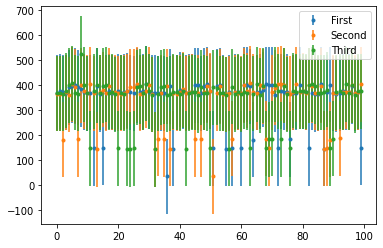

In [12]:
plt.errorbar(np.arange(100), idxs[:, -1], yerr=150*np.ones(100), fmt='.', label='First')
plt.errorbar(np.arange(100), idxs[:, -2], yerr=150*np.ones(100), fmt='.', label='Second')
plt.errorbar(np.arange(100), idxs[:, -3], yerr=150*np.ones(100), fmt='.', label='Third')
plt.legend()

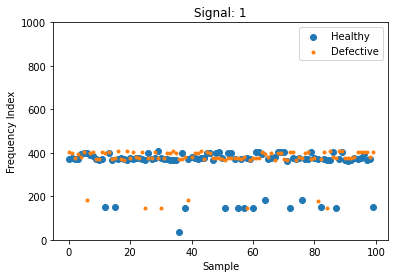

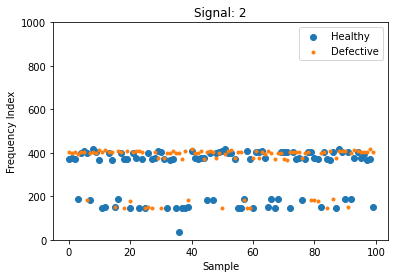

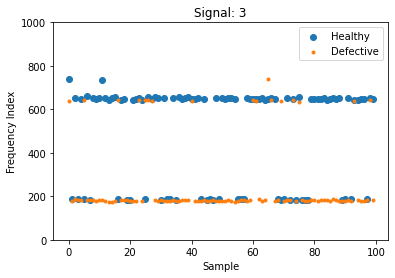

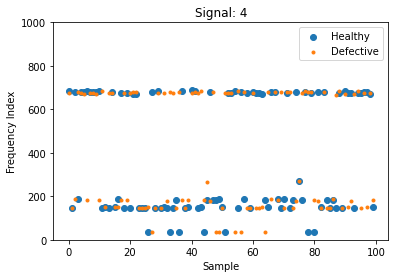

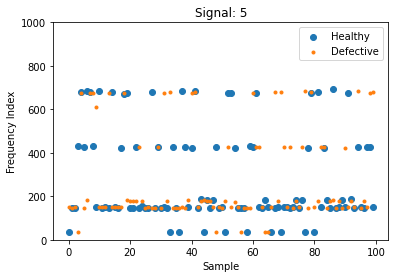

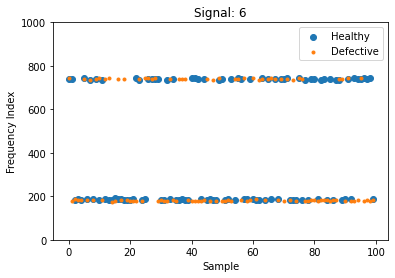

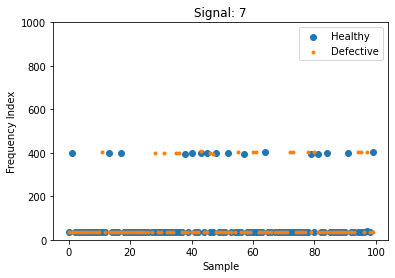

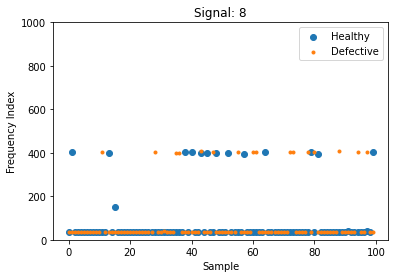

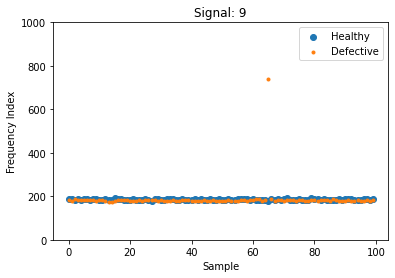

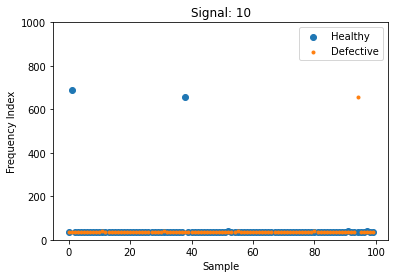

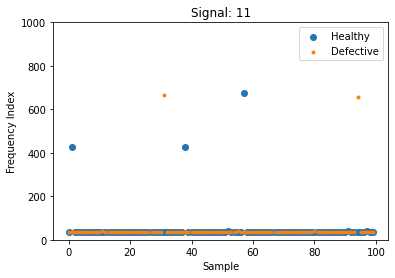

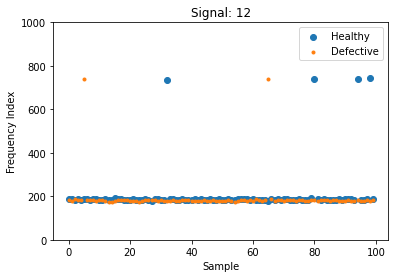

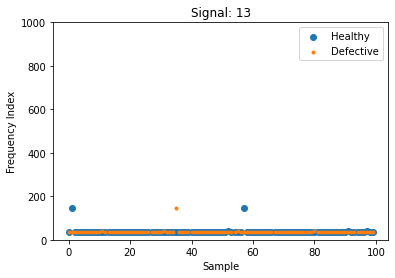

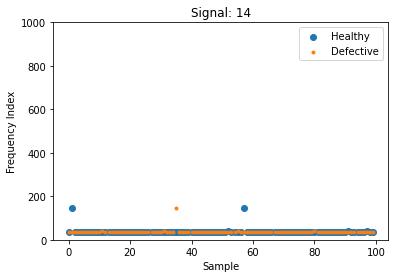

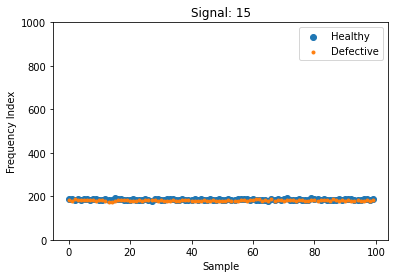

In [13]:
maxs_healthy = np.argmax(healthy, axis=-1)
maxs_defective = np.argmax(defective, axis=-1)
for signal in range(15):
    plt.figure()
    plt.scatter(np.arange(len(maxs_healthy[:, signal])), maxs_healthy[:, signal], label='Healthy')
    plt.scatter(np.arange(len(maxs_defective[:, signal])), maxs_defective[:, signal], label='Defective', marker='.')
    plt.title(f'Signal: {signal + 1}')
    plt.xlabel('Sample')
    plt.ylabel('Frequency Index')
    plt.ylim([0, dic[0].shape[2]])
    plt.legend()
    plt.savefig(f'figs/signal_{signal}')

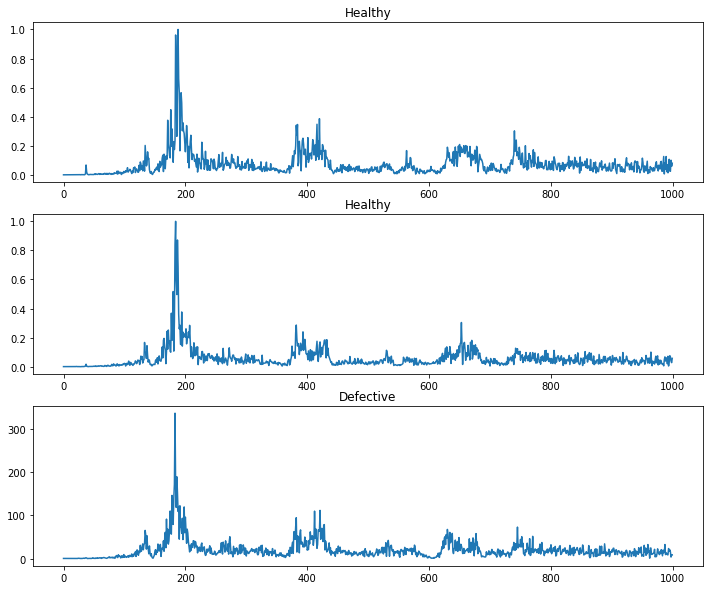

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
ax[0].plot(dic[0][0, 14, :])
ax[0].set_title('Healthy')
ax[1].plot(dic[0][10, 14, :])
ax[1].set_title('Healthy')
ax[2].plot(dic[17][10, 14, :])
ax[2].set_title('Defective')
plt.show()

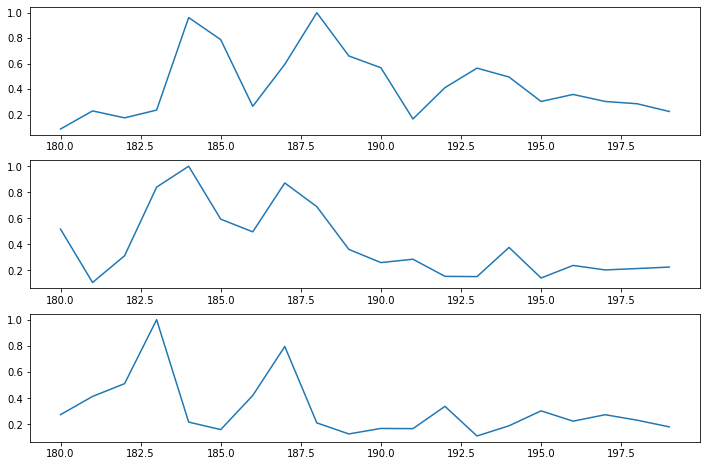

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(range(180, 200), dic[0][0, 14, 180:200])
ax[1].plot(range(180, 200), dic[0][10, 14, 180:200])
ax[2].plot(range(180, 200), dic[0][20, 14, 180:200])

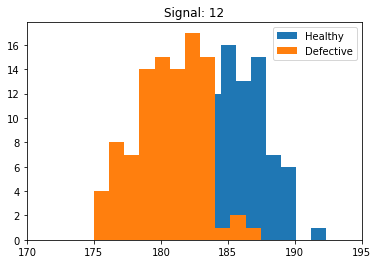

In [25]:
signal = 11
plt.hist(maxs_healthy[:, signal], bins=500, label='Healthy')
plt.hist(maxs_defective[:, signal], bins=500, label='Defective')
plt.xlim([170, 195])
plt.title(f'Signal: {signal + 1}')
plt.legend()
plt.show()

In [17]:
data = dataset(num_features=64)

In [18]:
data.keys()

dict_keys(['healthy', 'a1', 'a6', 'a17', 'a18'])

In [19]:
h = data['healthy']
d = data['a17'][40]

In [20]:
h_means = np.mean(h, axis=0)
h_stds = np.std(h, axis=0)
d_means = np.mean(d, axis=0)
d_stds = np.std(d, axis=0)

In [21]:
h_means[0], h_stds[0], d_means[0], d_stds[0]

(18.466854541909786,
 0.13744412273317763,
 17.79796925404189,
 0.1823015531790979)

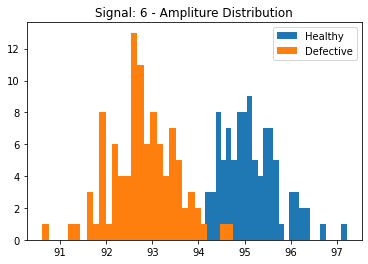

In [22]:
signal = 5
plt.hist(h[:, signal], bins=30, label='Healthy')
plt.hist(d[:, signal], bins=30, label='Defective')
plt.title(f'Signal: {signal + 1} - Ampliture Distribution')
plt.legend()
plt.show()

## Binary Classification

In [26]:
# multiple binary classifiers
n_classes = 2
data = dic
healthy = data[0]

healthy_small = np.zeros((healthy.shape[0], n_signal, n_signal))
for row in range(n_signal):
    arg = np.argmax(healthy[0, row, :])
    healthy_small[:, row, :] = healthy[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
for i in range(healthy_small.shape[0]):
    healthy_small[i, :, :] = norm_row(healthy_small[i, :, :])
healthy_data = np.expand_dims(healthy_small, axis=-1)
    
healthy_labels = to_categorical(np.zeros(healthy_data.shape[0]), num_classes=n_classes)

In [27]:
accs_dic = {}
for b in list(data.keys())[1:]:
    print(f'*** Beam: {b} ***')
    defective = data[b]
    
    defective_small = np.zeros((defective.shape[0], n_signal, n_signal))
    for row in range(n_signal):
        arg = np.argmax(defective[0, row, :])
        defective_small[:, row, :] = defective[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
    for i in range(defective_small.shape[0]):
        defective_small[i, :, :] = norm_row(defective_small[i, :, :])
    defective_data = np.expand_dims(defective_small, axis=-1)
    
    defective_labels = to_categorical(np.ones(defective_data.shape[0]), num_classes=n_classes)

    n_times = 1
    n_folds = 10
    idxs = list(range(healthy_data.shape[0]))
    accs = []
    for t in range(n_times):
        print(f'*** Iteration: {t + 1} / {n_times} ***')
        for i in range(n_folds):
            print(f'*** Fold: {i + 1} / {n_folds} ***')
            idxs_test = list(range(int(len(idxs) / n_folds) * i, int(len(idxs) / n_folds) * (i + 1)))
            idxs_train = [idx for idx in idxs if idx not in idxs_test]

            x_train = np.concatenate((healthy_data[idxs_train, :, :, :], defective_data[idxs_train, :, :, :]), axis=0)
            y_train = np.concatenate((healthy_labels[idxs_train, :], defective_labels[idxs_train, :]), axis=0)
            x_test = np.concatenate((healthy_data[idxs_test, :, :, :], defective_data[idxs_test, :, :, :]), axis=0)
            y_test = np.concatenate((healthy_labels[idxs_test, :], defective_labels[idxs_test, :]), axis=0)

            model = Sequential()
            model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(15, 15, 1)))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Flatten())
            model.add(Dropout(0.5))
            model.add(Dense(n_classes, activation='softmax'))

            ea = EarlyStopping(patience=100)
            cp = ModelCheckpoint('checkpoints/cnn.h5', save_best_only=True)
            cb = [ea, cp]

            model.compile('nadam', 'binary_crossentropy', ['accuracy'])
            history = model.fit(x_train, y_train, batch_size=2, verbose=0, epochs=1000, validation_split=0.2,
                                callbacks=cb)

            model = load_model('checkpoints/cnn.h5')
            test_accuracy = model.evaluate(x_test, y_test)[1]
            accs.append(test_accuracy)

            backend.clear_session()

    accs_dic[b] = np.mean(accs), np.std(accs)

*** Beam: 5 ***
*** Iteration: 1 / 1 ***
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 66ms/step - loss: 0.0887 - accuracy: 0.9500
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 252ms/step - loss: 5.9222e-04 - accuracy: 1.0000
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 66ms/step - loss: 1.2505e-04 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 64ms/step - loss: 0.0040 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 80ms/step - loss: 0.1210 - accuracy: 0.9500
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 63ms/step - loss: 0.0038 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 104ms/step - loss: 8.4120e-04 - accuracy: 1.0000
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 93ms/step - loss: 8.0555e-04 - accuracy: 1.0000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 98ms/step - loss: 0.00

1/1 [==============================] - 0s 65ms/step - loss: 0.0112 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 88ms/step - loss: 2.0187e-06 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 157ms/step - loss: 3.2234e-04 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 65ms/step - loss: 8.6710e-04 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 69ms/step - loss: 2.5589e-04 - accuracy: 1.0000
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 133ms/step - loss: 6.3822e-05 - accuracy: 1.0000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 70ms/step - loss: 3.5034e-05 - accuracy: 1.0000
*** Fold: 10 / 10 ***
1/1 [==============================] - 0s 69ms/step - loss: 4.9697e-05 - accuracy: 1.0000
*** Beam: 66 ***
*** Iteration: 1 / 1 ***
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 63ms/step - loss: 0.0011 - ac

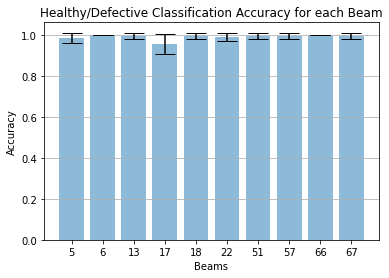

In [28]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(accs_dic)), [m[0] for m in accs_dic.values()], yerr=[m[1] for m in accs_dic.values()],
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Beams')
ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(len(accs_dic)))
ax.set_xticklabels(accs_dic.keys())
ax.yaxis.grid(True)
ax.set_title('Healthy/Defective Classification Accuracy for each Beam')
plt.show()

## Multi-class Classification

In [5]:
beams = [0, 6, 17, 22, 51, 57, 67]
multi_results = {}
for n_classes in range(3, 8):
    print(f'*** {n_classes} Classes ***')
    data = dic
    data_small = {}
    labels = {}

    healthy = data[0]
    healthy_small = np.zeros((healthy.shape[0], n_signal, n_signal))
    for row in range(n_signal):
        arg = np.argmax(healthy[0, row, :])
        healthy_small[:, row, :] = healthy[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
    for i in range(healthy_small.shape[0]):
        healthy_small[i, :, :] = norm_row(healthy_small[i, :, :])
    healthy_data = np.expand_dims(healthy_small, axis=-1)
    data_small[0] = healthy_data

    healthy_labels = np.zeros(healthy_data.shape[0])
    labels[0] = healthy_labels

    for j, b in enumerate(beams[1:n_classes]):
        defective = data[b]
        defective_small = np.zeros((defective.shape[0], n_signal, n_signal))
        for row in range(n_signal):
            arg = np.argmax(defective[0, row, :])
            defective_small[:, row, :] = defective[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
        for i in range(defective_small.shape[0]):
            defective_small[i, :, :] = norm_row(defective_small[i, :, :])
        defective_data = np.expand_dims(defective_small, axis=-1)
        data_small[b] = defective_data

        defective_labels = np.ones(defective_data.shape[0]) * (j + 1)
        labels[b] = defective_labels
    
    print(f'Classes: {data_small.keys()}')

    n_folds = 10
    idxs = list(range(data_small[0].shape[0]))
    accs = []
    for i in range(n_folds):
        print(f'*** Fold: {i + 1} / {n_folds} ***')
        idxs_test = list(range(int(len(idxs) / n_folds) * i, int(len(idxs) / n_folds) * (i + 1)))
        idxs_train = [idx for idx in idxs if idx not in idxs_test]

        train_data = {}
        train_labels = {}
        test_data = {}
        test_labels = {}
        for key in data_small.keys():
            train_data[key] = data_small[key][idxs_train, :, :, :]
            test_data[key] = data_small[key][idxs_test, :, :, :]
            train_labels[key] = to_categorical(labels[key][idxs_train], num_classes=n_classes)
            test_labels[key] = to_categorical(labels[key][idxs_test], num_classes=n_classes)

        x_train = np.concatenate(list(train_data.values()))
        y_train = np.concatenate(list(train_labels.values()))
        x_test = np.concatenate(list(test_data.values()))
        y_test = np.concatenate(list(test_labels.values()))

        model = Sequential()
        model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(15, 15, 1)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(n_classes, activation='softmax'))

        checkpoint_path = f'checkpoints/cnn_multi_not_order_{n_classes}.h5'
        ea = EarlyStopping(patience=100)
        cp = ModelCheckpoint(checkpoint_path, save_best_only=True)
        cb = [ea, cp]

        model.compile('nadam', 'binary_crossentropy', ['accuracy'])
        history = model.fit(x_train, y_train, batch_size=2, epochs=1000, validation_split=0.2, callbacks=cb, verbose=0)

        model.load_weights(checkpoint_path)
        test_accuracy = model.evaluate(x_test, y_test)[1]
        accs.append(test_accuracy)

        backend.clear_session()

    print(f'Accuracy Mean: {np.mean(accs)}')
    print(f'Accuracy Std: {np.std(accs)}')
    
    multi_results[n_classes] = np.mean(accs), np.std(accs)

*** 3 Classes ***
Classes: dict_keys([0, 6, 17])
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 143ms/step - loss: 0.0065 - accuracy: 1.0000
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 142ms/step - loss: 0.0084 - accuracy: 1.0000
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 148ms/step - loss: 0.0341 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 138ms/step - loss: 0.0036 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 155ms/step - loss: 0.0065 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 133ms/step - loss: 0.0573 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 87ms/step - loss: 0.0267 - accuracy: 1.0000
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 101ms/step - loss: 0.0096 - accuracy: 1.0000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 99ms/step - loss: 0.0173 

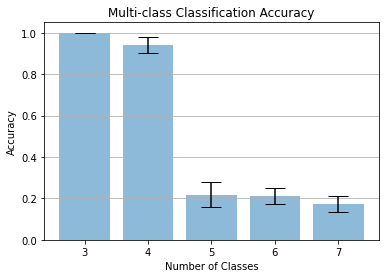

In [6]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(multi_results)), [m[0] for m in multi_results.values()], yerr=[m[1] for m in multi_results.values()],
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Number of Classes')
ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(len(multi_results)))
ax.set_xticklabels(multi_results.keys())
ax.yaxis.grid(True)
ax.set_title('Multi-class Classification Accuracy')
plt.show()

In [45]:
beams = [0, 5, 6, 13, 17, 18, 22, 51, 57, 66, 67]
n_classes = 4

data = dic
data_small = {}
labels = {}

healthy = data[0]
healthy_small = np.zeros((healthy.shape[0], n_signal, n_signal))
for row in range(n_signal):
    arg = np.argmax(healthy[0, row, :])
    healthy_small[:, row, :] = healthy[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
for i in range(healthy_small.shape[0]):
    healthy_small[i, :, :] = norm_row(healthy_small[i, :, :])
healthy_data = np.expand_dims(healthy_small, axis=-1)[:11, :, :, :]
data_small[0] = healthy_data

healthy_labels = np.zeros(healthy_data.shape[0])
labels[0] = healthy_labels

for j, b in enumerate(beams[1:n_classes]):
    defective = data[b]
    defective_small = np.zeros((defective.shape[0], n_signal, n_signal))
    for row in range(n_signal):
        arg = np.argmax(defective[0, row, :])
        defective_small[:, row, :] = defective[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
    for i in range(defective_small.shape[0]):
        defective_small[i, :, :] = norm_row(defective_small[i, :, :])
    defective_data = np.expand_dims(defective_small, axis=-1)[:11, :, :, :]
    data_small[b] = defective_data

    defective_labels = np.ones(defective_data.shape[0]) * (j + 1)
    labels[b] = defective_labels

print(f'Classes: {data_small.keys()}')

n_folds = 10
idxs = list(range(data_small[0].shape[0]))
i = 1

idxs_test = list(range(int(len(idxs) / n_folds) * i, int(len(idxs) / n_folds) * (i + 1)))
idxs_train = [idx for idx in idxs if idx not in idxs_test]

train_data = {}
train_labels = {}
test_data = {}
test_labels = {}
for key in data_small.keys():
    train_data[key] = data_small[key][idxs_train, :, :, :]
    test_data[key] = data_small[key][idxs_test, :, :, :]
    train_labels[key] = to_categorical(labels[key][idxs_train], num_classes=n_classes)
    test_labels[key] = to_categorical(labels[key][idxs_test], num_classes=n_classes)

x_train = np.concatenate(list(train_data.values()))
y_train = np.concatenate(list(train_labels.values()))
x_test = np.concatenate(list(test_data.values()))
y_test = np.concatenate(list(test_labels.values()))

model = Sequential()
model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(15, 15, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

checkpoint_path = f'checkpoints/cnn_multi_not_order_{n_classes}.h5'
ea = EarlyStopping(patience=100)
cp = ModelCheckpoint(checkpoint_path, save_best_only=True)
cb = [ea, cp]

model.compile('nadam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(x_train, y_train, batch_size=2, epochs=1000, validation_split=0.2, callbacks=cb, verbose=0)

model.load_weights(checkpoint_path)
test_accuracy = model.evaluate(x_test, y_test)[1]

predictions = model.predict(x_test)

Classes: dict_keys([0, 5, 6, 13])
1/1 [==============================] - 0s 61ms/step - loss: 1.4028 - accuracy: 0.2500


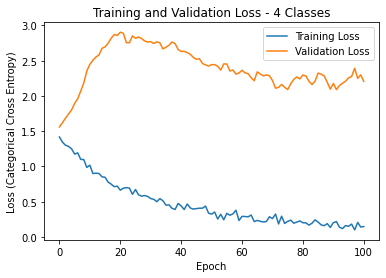

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Categorical Cross Entropy)')
plt.title(f'Training and Validation Loss - {n_classes} Classes')
plt.legend()
plt.show()

In [47]:
y_pred = np.argmax(predictions, axis=1)
conf = confusion_matrix(np.argmax(y_test, axis=1), y_pred, normalize='true')

In [48]:
print(conf)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [55]:
beams = [0, 5, 6, 13, 17, 18, 22, 51, 57, 66, 67]
n_classes = 4
print(f'Classes: {beams[:4]}')

res = []
for k in range(10, 101, 10):
    data = dic
    data_small = {}
    labels = {}

    healthy = data[0]
    healthy_small = np.zeros((healthy.shape[0], n_signal, n_signal))
    for row in range(n_signal):
        arg = np.argmax(healthy[0, row, :])
        healthy_small[:, row, :] = healthy[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
    for i in range(healthy_small.shape[0]):
        healthy_small[i, :, :] = norm_row(healthy_small[i, :, :])
    healthy_data = np.expand_dims(healthy_small, axis=-1)[:k, :, :, :]
    data_small[0] = healthy_data

    healthy_labels = np.zeros(healthy_data.shape[0])
    labels[0] = healthy_labels

    for j, b in enumerate(beams[1:n_classes]):
        defective = data[b]
        defective_small = np.zeros((defective.shape[0], n_signal, n_signal))
        for row in range(n_signal):
            arg = np.argmax(defective[0, row, :])
            defective_small[:, row, :] = defective[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
        for i in range(defective_small.shape[0]):
            defective_small[i, :, :] = norm_row(defective_small[i, :, :])
        defective_data = np.expand_dims(defective_small, axis=-1)[:k, :, :, :]
        data_small[b] = defective_data

        defective_labels = np.ones(defective_data.shape[0]) * (j + 1)
        labels[b] = defective_labels

    n_folds = 10
    idxs = list(range(data_small[0].shape[0]))
    i = 1

    idxs_test = list(range(int(len(idxs) / n_folds) * i, int(len(idxs) / n_folds) * (i + 1)))
    idxs_train = [idx for idx in idxs if idx not in idxs_test]

    train_data = {}
    train_labels = {}
    test_data = {}
    test_labels = {}
    for key in data_small.keys():
        train_data[key] = data_small[key][idxs_train, :, :, :]
        test_data[key] = data_small[key][idxs_test, :, :, :]
        train_labels[key] = to_categorical(labels[key][idxs_train], num_classes=n_classes)
        test_labels[key] = to_categorical(labels[key][idxs_test], num_classes=n_classes)

    x_train = np.concatenate(list(train_data.values()))
    y_train = np.concatenate(list(train_labels.values()))
    x_test = np.concatenate(list(test_data.values()))
    y_test = np.concatenate(list(test_labels.values()))

    model = Sequential()
    model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(15, 15, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    checkpoint_path = f'checkpoints/cnn_multi_not_order_{n_classes}.h5'
    ea = EarlyStopping(patience=100)
    cp = ModelCheckpoint(checkpoint_path, save_best_only=True)
    cb = [ea, cp]

    model.compile('nadam', 'categorical_crossentropy', ['accuracy'])
    history = model.fit(x_train, y_train, batch_size=2, epochs=1000, validation_split=0.2, callbacks=cb, verbose=0)

    model.load_weights(checkpoint_path)
    test_accuracy = model.evaluate(x_test, y_test)[1]
    res.append(test_accuracy)

Classes: [0, 5, 6, 13]


KeyboardInterrupt: 

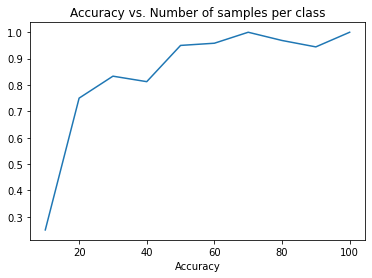

In [51]:
plt.plot(range(10, 101, 10), res)
plt.xlabel('Numer of samples per class')
plt.xlabel('Accuracy')
plt.title('Accuracy vs. Number of samples per class')
plt.show()

In [73]:
results = {}
for n_classes in range(2, 12):
    print(f'*** Number of classes: {n_classes} ***')
    data = dic
    data_small = {}
    labels = {}

    healthy = data[0]
    healthy_small = np.zeros((healthy.shape[0], n_signal, n_signal))
    for row in range(n_signal):
        arg = np.argmax(healthy[0, row, :])
        healthy_small[:, row, :] = healthy[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
    for i in range(healthy_small.shape[0]):
        healthy_small[i, :, :] = norm_row(healthy_small[i, :, :])
    healthy_data = np.expand_dims(healthy_small, axis=-1)
    data_small[0] = healthy_data

    healthy_labels = np.zeros(healthy_data.shape[0])
    labels[0] = healthy_labels

    for j, b in enumerate(list(data.keys())[1:n_classes]):
        defective = data[b]
        defective_small = np.zeros((defective.shape[0], n_signal, n_signal))
        for row in range(n_signal):
            arg = np.argmax(defective[0, row, :])
            defective_small[:, row, :] = defective[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
        for i in range(defective_small.shape[0]):
            defective_small[i, :, :] = norm_row(defective_small[i, :, :])
        defective_data = np.expand_dims(defective_small, axis=-1)
        data_small[b] = defective_data

        defective_labels = np.ones(defective_data.shape[0]) * (j + 1)
        labels[b] = defective_labels

    print(f'Classes: {data_small.keys()}')
    
    n_folds = 10
    idxs = list(range(data_small[0].shape[0]))
    accs = []
    for i in range(n_folds):
        print(f'*** Fold: {i + 1} / {n_folds} ***')
        idxs_test = list(range(int(len(idxs) / n_folds) * i, int(len(idxs) / n_folds) * (i + 1)))
        idxs_train = [idx for idx in idxs if idx not in idxs_test]

        train_data = {}
        train_labels = {}
        test_data = {}
        test_labels = {}
        for key in data_small.keys():
            train_data[key] = data_small[key][idxs_train, :, :, :]
            test_data[key] = data_small[key][idxs_test, :, :, :]
            train_labels[key] = to_categorical(labels[key][idxs_train], num_classes=n_classes)
            test_labels[key] = to_categorical(labels[key][idxs_test], num_classes=n_classes)

        x_train = np.concatenate(list(train_data.values()))
        y_train = np.concatenate(list(train_labels.values()))
        x_test = np.concatenate(list(test_data.values()))
        y_test = np.concatenate(list(test_labels.values()))

        model = Sequential()
        model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(15, 15, 1)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(n_classes, activation='softmax'))

        checkpoint_path = f'checkpoints/cnn_multi_{n_classes}.h5'
        ea = EarlyStopping(patience=100)
        cp = ModelCheckpoint(checkpoint_path, save_best_only=True)
        cb = [ea, cp]

        model.compile('nadam', 'binary_crossentropy', ['accuracy'])
        history = model.fit(x_train, y_train, batch_size=2, epochs=1000, validation_split=0.2, callbacks=cb, verbose=0)

        model.load_weights(checkpoint_path)
        test_accuracy = model.evaluate(x_test, y_test)[1]
        accs.append(test_accuracy)

        backend.clear_session()

    print(f'Accuracy Mean: {np.mean(accs)}')
    print(f'Accuracy Std: {np.std(accs)}')
    results[n_classes] = np.mean(accs), np.std(accs)

*** Number of classes: 2 ***
Classes: dict_keys([0, 5])
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 52ms/step - loss: 0.5071 - accuracy: 0.8500
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 85ms/step - loss: 0.5105 - accuracy: 0.7500
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 80ms/step - loss: 0.1232 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 84ms/step - loss: 0.3172 - accuracy: 0.9000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 81ms/step - loss: 0.1312 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 77ms/step - loss: 0.3716 - accuracy: 0.7500
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 81ms/step - loss: 0.3452 - accuracy: 0.8500
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 103ms/step - loss: 0.3335 - accuracy: 0.8000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 85ms/step - loss: 0.3558

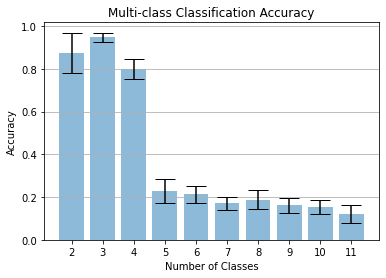

In [77]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(results)), [m[0] for m in results.values()], yerr=[m[1] for m in results.values()],
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Number of Classes')
ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(len(results)))
ax.set_xticklabels(results.keys())
ax.yaxis.grid(True)
ax.set_title('Multi-class Classification Accuracy')
plt.show()

### Merging 2 defective classes together

In [45]:
beams = [0, 5, 6, 13, 17, 18, 22, 51, 57, 66, 67]
n_classes = 9

data = dic
data_small = {}
labels = {}

healthy = data[0]
healthy_small = np.zeros((healthy.shape[0], n_signal, n_signal))
for row in range(n_signal):
    arg = np.argmax(healthy[0, row, :])
    healthy_small[:, row, :] = healthy[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
for i in range(healthy_small.shape[0]):
    healthy_small[i, :, :] = norm_row(healthy_small[i, :, :])
healthy_data = np.expand_dims(healthy_small, axis=-1)
data_small[0] = healthy_data

for j, b in enumerate(beams[1:n_classes]):
    defective = data[b]
    defective_small = np.zeros((defective.shape[0], n_signal, n_signal))
    for row in range(n_signal):
        arg = np.argmax(defective[0, row, :])
        defective_small[:, row, :] = defective[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
    for i in range(defective_small.shape[0]):
        defective_small[i, :, :] = norm_row(defective_small[i, :, :])
    defective_data = np.expand_dims(defective_small, axis=-1)
    data_small[b] = defective_data


print(f'Classes: {data_small.keys()}')

data_new = {}
data_new[0] = data_small[0]
data_new[1] = np.concatenate((data_small[5][:, :, :, :], data_small[6][:, :, :, :]), axis=0)
data_new[2] = np.concatenate((data_small[13][:, :, :, :], data_small[17][:, :, :, :]), axis=0)
data_new[3] = np.concatenate((data_small[18][:, :, :, :], data_small[22][:, :, :, :]), axis=0)
data_new[4] = np.concatenate((data_small[51][:, :, :, :], data_small[57][:, :, :, :]), axis=0)

labels[0] = np.zeros(data_new[0].shape[0])
labels[1] = np.ones(data_new[1].shape[0])
labels[2] = np.ones(data_new[2].shape[0]) * 2
labels[3] = np.ones(data_new[3].shape[0]) * 3
labels[4] = np.ones(data_new[3].shape[0]) * 4

n_classes = 5

n_folds = 10
idxs = list(range(data_new[0].shape[0]))
i = 1

idxs_test = list(range(int(len(idxs) / n_folds) * i, int(len(idxs) / n_folds) * (i + 1)))
idxs_train = [idx for idx in idxs if idx not in idxs_test]

train_data = {}
train_labels = {}
test_data = {}
test_labels = {}
for key in data_new.keys():
    train_data[key] = data_new[key][idxs_train, :, :, :]
    test_data[key] = data_new[key][idxs_test, :, :, :]
    train_labels[key] = to_categorical(labels[key][idxs_train], num_classes=n_classes)
    test_labels[key] = to_categorical(labels[key][idxs_test], num_classes=n_classes)

x_train = np.concatenate(list(train_data.values()))
y_train = np.concatenate(list(train_labels.values()))
x_test = np.concatenate(list(test_data.values()))
y_test = np.concatenate(list(test_labels.values()))

model = Sequential()
model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(15, 15, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

checkpoint_path = f'checkpoints/cnn_multi_not_order_{n_classes}.h5'
ea = EarlyStopping(patience=100)
cp = ModelCheckpoint(checkpoint_path, save_best_only=True)
cb = [ea, cp]

model.compile('nadam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(x_train, y_train, batch_size=2, epochs=1000, validation_split=0.2, callbacks=cb, verbose=0)

model.load_weights(checkpoint_path)
test_accuracy = model.evaluate(x_test, y_test)[1]

predictions = model.predict(x_test)

Classes: dict_keys([0, 5, 6, 13, 17, 18, 22, 51, 57])
2/2 [==============================] - 0s 3ms/step - loss: 1.7627 - accuracy: 0.5000


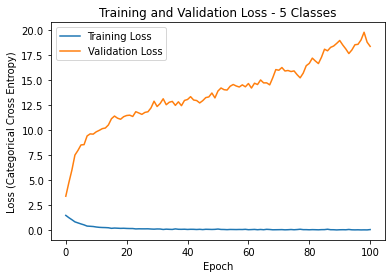

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Categorical Cross Entropy)')
plt.title('Training and Validation Loss - 5 Classes')
plt.legend()
plt.show()

In [47]:
y_pred = np.argmax(predictions, axis=1)
conf = confusion_matrix(np.argmax(y_test, axis=1), y_pred, normalize='true')

In [48]:
conf

array([[0.5, 0. , 0.1, 0.4, 0. ],
       [0.3, 0.5, 0. , 0.2, 0. ],
       [0. , 0. , 0.9, 0.1, 0. ],
       [0.2, 0.1, 0.1, 0.6, 0. ],
       [0.2, 0.2, 0.1, 0.5, 0. ]])

### 2 by 2 Classification

In [5]:
beams = [0, 5, 6, 13, 17, 18, 22, 51, 57, 66, 67]
data = dic
data_small = {}
n_classes = 2

for j, b in enumerate(beams):
    defective = data[b]
    defective_small = np.zeros((defective.shape[0], n_signal, n_signal))
    for row in range(n_signal):
        arg = np.argmax(defective[0, row, :])
        defective_small[:, row, :] = defective[:, row, (arg - int(n_signal / 2)):(arg + int(n_signal / 2) + 1)]
    for i in range(defective_small.shape[0]):
        defective_small[i, :, :] = norm_row(defective_small[i, :, :])
    defective_data = np.expand_dims(defective_small, axis=-1)
    data_small[b] = defective_data
    
df = pd.DataFrame(index=beams, columns=beams)

In [6]:
for c1 in beams:
    for c2 in beams[beams.index(c1) + 1:]:
        print(f'Classes: {c1, c2}')
        n_folds = 10
        idxs = list(range(data_small[0].shape[0]))
        accs = []
        for i in range(n_folds):
            print(f'*** Fold: {i + 1} / {n_folds} ***')
            idxs_test = list(range(int(len(idxs) / n_folds) * i, int(len(idxs) / n_folds) * (i + 1)))
            idxs_train = [idx for idx in idxs if idx not in idxs_test]
            
            healthy_data = data_small[c1]
            defective_data = data_small[c2]
            healthy_labels = to_categorical(np.zeros(healthy_data.shape[0]), num_classes=2)
            defective_labels = to_categorical(np.ones(defective_data.shape[0]), num_classes=2)

            x_train = np.concatenate((healthy_data[idxs_train, :, :, :], defective_data[idxs_train, :, :, :]), axis=0)
            y_train = np.concatenate((healthy_labels[idxs_train, :], defective_labels[idxs_train, :]), axis=0)
            x_test = np.concatenate((healthy_data[idxs_test, :, :, :], defective_data[idxs_test, :, :, :]), axis=0)
            y_test = np.concatenate((healthy_labels[idxs_test, :], defective_labels[idxs_test, :]), axis=0)

            model = Sequential()
            model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(15, 15, 1)))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Flatten())
            model.add(Dropout(0.5))
            model.add(Dense(n_classes, activation='softmax'))

            ea = EarlyStopping(patience=100)
            cp = ModelCheckpoint('checkpoints/cnn.h5', save_best_only=True)
            cb = [ea, cp]

            model.compile('nadam', 'binary_crossentropy', ['accuracy'])
            history = model.fit(x_train, y_train, batch_size=2, verbose=0, epochs=1000, validation_split=0.2,
                                callbacks=cb)

            model = load_model('checkpoints/cnn.h5')
            test_accuracy = model.evaluate(x_test, y_test)[1]
            accs.append(test_accuracy)

            backend.clear_session()
            
        df[c2].loc[c1] = np.mean(accs), np.std(accs)

Classes: (0, 5)
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 124ms/step - loss: 0.0937 - accuracy: 0.9500
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 209ms/step - loss: 2.3358e-04 - accuracy: 1.0000
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 164ms/step - loss: 7.5104e-04 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 305ms/step - loss: 0.0041 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 182ms/step - loss: 0.0297 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 153ms/step - loss: 9.6725e-04 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 91ms/step - loss: 4.8189e-04 - accuracy: 1.0000
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 146ms/step - loss: 0.0030 - accuracy: 1.0000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 179ms/step - loss: 0.0014 - accuracy: 1.00

1/1 [==============================] - 0s 111ms/step - loss: 6.5894e-05 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 125ms/step - loss: 1.2187e-04 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 96ms/step - loss: 0.0010 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 124ms/step - loss: 6.7394e-06 - accuracy: 1.0000
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 204ms/step - loss: 2.5265e-04 - accuracy: 1.0000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 122ms/step - loss: 1.4106e-05 - accuracy: 1.0000
*** Fold: 10 / 10 ***
1/1 [==============================] - 0s 116ms/step - loss: 2.0417e-04 - accuracy: 1.0000
Classes: (0, 66)
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 96ms/step - loss: 0.0103 - accuracy: 1.0000
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 82ms/step - loss: 6.9273e-04 - accuracy: 1.0000
*** Fo

1/1 [==============================] - 0s 110ms/step - loss: 5.0822e-04 - accuracy: 1.0000
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 122ms/step - loss: 1.9649e-05 - accuracy: 1.0000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 116ms/step - loss: 0.0990 - accuracy: 0.9500
*** Fold: 10 / 10 ***
1/1 [==============================] - 0s 98ms/step - loss: 2.2629e-05 - accuracy: 1.0000
Classes: (5, 51)
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 110ms/step - loss: 0.0104 - accuracy: 1.0000
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 92ms/step - loss: 3.9049e-05 - accuracy: 1.0000
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 137ms/step - loss: 2.1948e-04 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 119ms/step - loss: 0.0030 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 100ms/step - loss: 7.4332e-05 - accuracy: 1.0000
*** Fold:

*** Fold: 10 / 10 ***
1/1 [==============================] - 0s 79ms/step - loss: 1.4670e-06 - accuracy: 1.0000
Classes: (6, 22)
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 112ms/step - loss: 2.8444e-05 - accuracy: 1.0000
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 200ms/step - loss: 1.8291e-06 - accuracy: 1.0000
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 204ms/step - loss: 5.8526e-07 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 78ms/step - loss: 9.0943e-09 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 120ms/step - loss: 1.7737e-06 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 81ms/step - loss: 5.3778e-07 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 85ms/step - loss: 2.9141e-06 - accuracy: 1.0000
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 80ms/step - loss: 1.2869e-0

1/1 [==============================] - 0s 139ms/step - loss: 0.0659 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 82ms/step - loss: 0.0359 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 136ms/step - loss: 0.0021 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 78ms/step - loss: 0.0094 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 369ms/step - loss: 0.1158 - accuracy: 0.9500
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 121ms/step - loss: 0.0769 - accuracy: 0.9500
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 122ms/step - loss: 0.0121 - accuracy: 1.0000
*** Fold: 10 / 10 ***
1/1 [==============================] - 0s 102ms/step - loss: 0.0659 - accuracy: 0.9500
Classes: (13, 51)
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 112ms/step - loss: 0.0043 - accuracy: 1.0000
*** Fold: 2 / 10 ***
1/1 [======

1/1 [==============================] - 0s 261ms/step - loss: 1.9302e-04 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 103ms/step - loss: 2.8219e-05 - accuracy: 1.0000
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 201ms/step - loss: 0.0021 - accuracy: 1.0000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 140ms/step - loss: 0.0045 - accuracy: 1.0000
*** Fold: 10 / 10 ***
1/1 [==============================] - 1s 538ms/step - loss: 0.0110 - accuracy: 1.0000
Classes: (17, 57)
*** Fold: 1 / 10 ***
1/1 [==============================] - 0s 87ms/step - loss: 0.0026 - accuracy: 1.0000
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 121ms/step - loss: 0.1472 - accuracy: 0.9500
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 110ms/step - loss: 7.6085e-05 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 125ms/step - loss: 1.8450e-04 - accuracy: 1.0000
*** Fold: 5 / 1

1/1 [==============================] - 0s 456ms/step - loss: 4.0725e-07 - accuracy: 1.0000
*** Fold: 10 / 10 ***
1/1 [==============================] - 1s 677ms/step - loss: 1.1851e-05 - accuracy: 1.0000
Classes: (18, 67)
*** Fold: 1 / 10 ***
1/1 [==============================] - 1s 503ms/step - loss: 0.0122 - accuracy: 1.0000
*** Fold: 2 / 10 ***
1/1 [==============================] - 0s 498ms/step - loss: 1.8723e-08 - accuracy: 1.0000
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 180ms/step - loss: 2.0831e-04 - accuracy: 1.0000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 122ms/step - loss: 1.2180e-07 - accuracy: 1.0000
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 275ms/step - loss: 0.0024 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 114ms/step - loss: 1.7749e-06 - accuracy: 1.0000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 108ms/step - loss: 2.2199e-06 - accuracy: 1.0000
**

1/1 [==============================] - 0s 95ms/step - loss: 0.0264 - accuracy: 1.0000
*** Fold: 3 / 10 ***
1/1 [==============================] - 0s 107ms/step - loss: 0.2813 - accuracy: 0.9000
*** Fold: 4 / 10 ***
1/1 [==============================] - 0s 110ms/step - loss: 0.0860 - accuracy: 0.9500
*** Fold: 5 / 10 ***
1/1 [==============================] - 0s 93ms/step - loss: 0.0220 - accuracy: 1.0000
*** Fold: 6 / 10 ***
1/1 [==============================] - 0s 115ms/step - loss: 0.2129 - accuracy: 0.9000
*** Fold: 7 / 10 ***
1/1 [==============================] - 0s 98ms/step - loss: 0.1483 - accuracy: 0.9500
*** Fold: 8 / 10 ***
1/1 [==============================] - 0s 92ms/step - loss: 0.0124 - accuracy: 1.0000
*** Fold: 9 / 10 ***
1/1 [==============================] - 0s 94ms/step - loss: 0.1211 - accuracy: 0.9500
*** Fold: 10 / 10 ***
1/1 [==============================] - 0s 98ms/step - loss: 0.1992 - accuracy: 0.9000
Classes: (57, 66)
*** Fold: 1 / 10 ***
1/1 [==========

In [25]:
df

,0,5,6,13,17,18,22,51,57,66,67
0,NaN,"(0.9899999976158143, 0.02000000476837158)","(1.0, 0.0)","(0.9949999988079071, 0.015000003576278688)","(0.949999988079071, 0.050000011920928955)","(0.9949999988079071, 0.015000003576278688)","(0.9899999976158143, 0.020000004768371583)","(1.0, 0.0)","(0.9949999988079071, 0.015000003576278688)","(1.0, 0.0)","(0.9849999964237213, 0.022912883937635128)"
5,NaN,NaN,"(1.0, 0.0)","(0.9949999988079071, 0.015000003576278688)","(1.0, 0.0)","(0.9949999988079071, 0.015000003576278688)","(0.9949999988079071, 0.015000003576278686)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.9949999988079071, 0.015000003576278688)"
6,NaN,NaN,NaN,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
13,NaN,NaN,NaN,NaN,"(0.9949999988079071, 0.015000003576278688)","(1.0, 0.0)","(0.9799999952316284, 0.02449490326787042)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
17,NaN,NaN,NaN,NaN,NaN,"(0.9949999988079071, 0.015000003576278688)","(0.9949999988079071, 0.015000003576278686)","(1.0, 0.0)","(0.9949999988079071, 0.015000003576278688)","(1.0, 0.0)","(0.9899999976158143, 0.02000000476837158)"
18,NaN,NaN,NaN,NaN,NaN,NaN,"(0.9849999964237213, 0.022912883937635128)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.9949999988079071, 0.015000003576278688)"
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.9949999988079071, 0.015000003576278688)","(1.0, 0.0)","(0.9449999868869782, 0.041533129216857666)"
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0)","(0.9699999928474426, 0.024494903267870422)"
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0)"
